# Forecasting with sktime

In forecasting, we're interested in using past data to make temporal forward predictions. sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.

For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.

In particular, you'll learn how to

* use statistical models to make forecasts,
* build composite machine learning models, including common techniques like reduction to regression, ensembling and pipelining.

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

%matplotlib inline

## Data
For this tutorial, we will use the famous Box-Jenkins airline data set, which shows the number of international airline
passengers per month from 1949-1960.

As well as using the original time series (which is a classic example of a *multiplicative* time series), we will create an *additive* time series by performing a log-transform on the original data, so we may compare forecasters against both types of model.

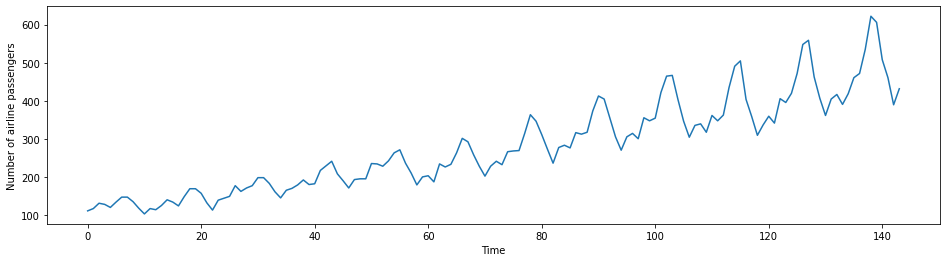

In [2]:
y = load_airline()
fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

Next we will define a forecasting task.

* We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.

We can split the data as follows:

In [3]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


When we want to generate forecasts, we need to specify the forecasting horizon and pass that to our forecasting algorithm. We can specify the forecasting horizon as a simple numpy array of the steps ahead, relative to the end of the training series:

In [4]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

## Forecasting

Like in scikit-learn, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

### Naïve baselines
Let's start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.

1. We always predict the last value observed (in the training series),
2. We predict the last value observed in the same season.

In [5]:
from sktime.forecasting.naive import NaiveForecaster

In [6]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_last = forecaster.predict(fh)
smape_loss(y_last, y_test)

0.23195770387951434

In [7]:
forecaster = NaiveForecaster(strategy="seasonal_last", sp=12)
forecaster.fit(y_train)
y_last_seasonal = forecaster.predict(fh)
smape_loss(y_last_seasonal, y_test)

0.145427686270316

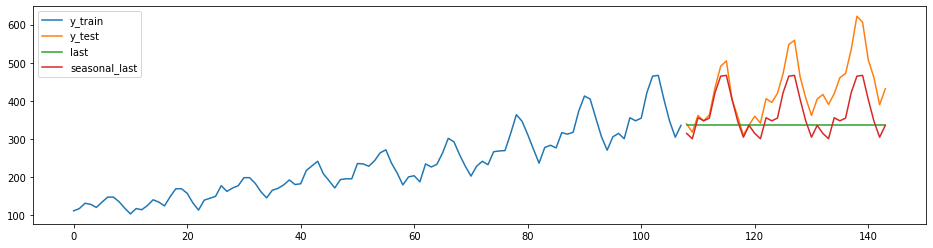

In [8]:
plot_ys(y_train, y_test, y_last, y_last_seasonal,
        labels=["y_train", "y_test", "last", "seasonal_last"]);

### Statistical forecasters

sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.

Note that since this is monthly data, the seasonal periodicity (sp), or the number of periods per year, is 12.

0.05108938804982467

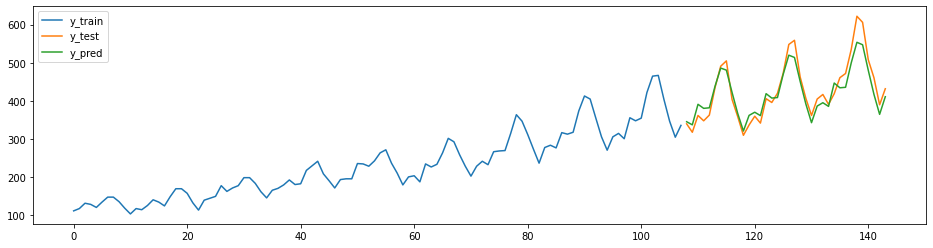

In [9]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

Another common model is the ARIMA model. In sktime, we interface [pmdarima](https://github.com/alkaline-ml/pmdarima), a package for automatically selecting the best ARIMA model. This since searches over a number of possible model parametrisations, it may take a bit longer.

0.07788559028091387

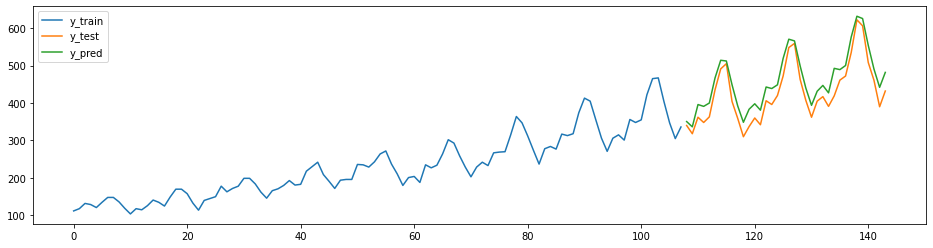

In [10]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Compositite model building

sktime provides a modular API for composite model building for forecasting.

### Ensembling
Like scikit-learn, sktime provides a meta-forecaster to ensemble multiple forecasting algorithms. For example, we can combine different variants of exponential smoothing as follows:

0.07028254231084805

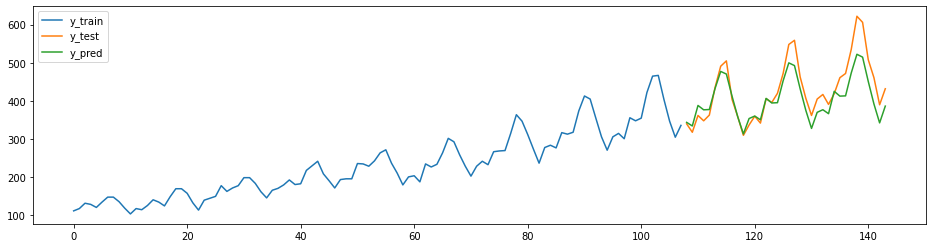

In [11]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

### Applying machine learning: reduction to regression
Forecasting is often solved via regression. This approach is sometimes called reduction, because we reduce the forecasting task to the simpler but related task of tabular regression. This allows apply any regression algorithm to the forecasting problem.

Reduction to regression works as follows: We first need to transform the data into the required tabular format. We can do this by cutting the training series into windows of a fixed length and stacking them on top of each other. Our target variable consist of the subsequent observation for each window.

sktime provides a meta-estimator for this approach, which is compatible with scikit-learn, so that we can use any scikit-learn regressor to solve our forecasting problem.

0.145427686270316

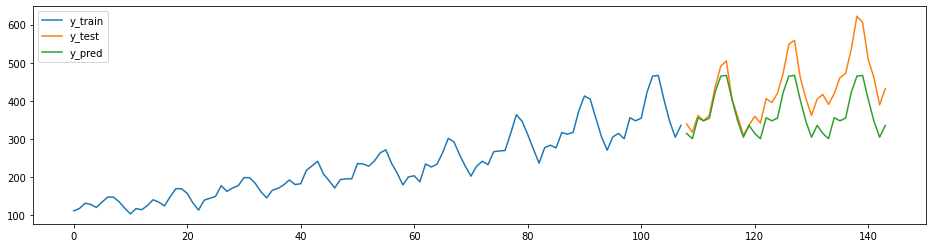

In [12]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=10, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

To better understand the prior data transformation, we can look at how we can split the training series into windows. Internally, sktime uses a temporal time series splitter, similar to the cross-validation splitter in scikit-learn. Here we show how this works for the first 20 observations of the training series:

In [13]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
cv = SlidingWindowSplitter(window_length=10, start_with_window=True)
for input_window, output_window in cv.split(y_train.iloc[:20]):
    print(input_window, output_window)

[0 1 2 3 4 5 6 7 8 9] [10]
[ 1  2  3  4  5  6  7  8  9 10] [11]
[ 2  3  4  5  6  7  8  9 10 11] [12]
[ 3  4  5  6  7  8  9 10 11 12] [13]
[ 4  5  6  7  8  9 10 11 12 13] [14]
[ 5  6  7  8  9 10 11 12 13 14] [15]
[ 6  7  8  9 10 11 12 13 14 15] [16]
[ 7  8  9 10 11 12 13 14 15 16] [17]
[ 8  9 10 11 12 13 14 15 16 17] [18]
[ 9 10 11 12 13 14 15 16 17 18] [19]


## Tuning
In the `ReducedRegressionForecaster`, both the `window_length` and `strategy` arguments are hyper-parameters which we may want to optimise.

In [14]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

0.14187443909112035

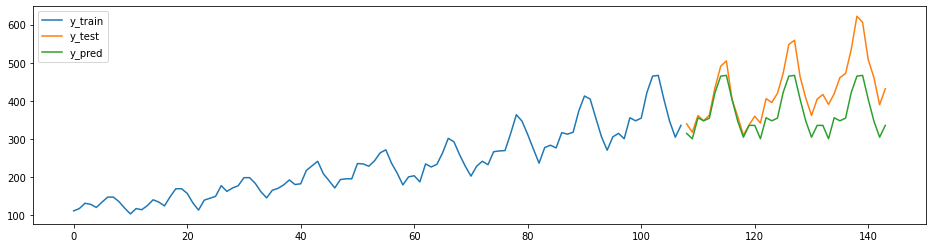

In [15]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [16]:
gscv.best_params_

{'window_length': 15}

You could of course also try to tune the regressor inside `ReducedRegressionForecaster` using scikit-learn's `GridSearchCV`.

### Detrending
Note that so far the reduction approach above does not take any seasonal or trend into account, but we can easily specify a pipeline which first detrends the data.

sktime provides a generic detrender, a transformer which uses any forecaster and returns the in-sample residuals of the forecaster's predicted values. For example, to remove the linear trend of a time series, we can write:

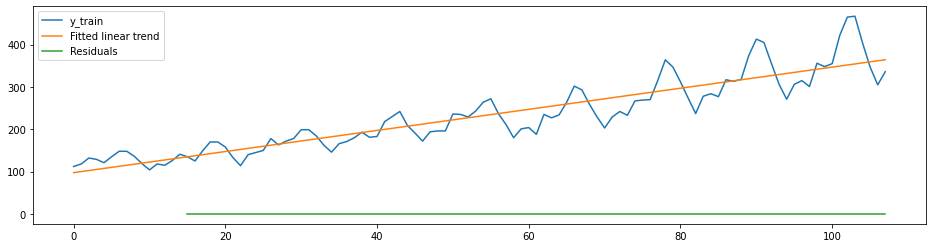

In [17]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender

# liner detrending
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_ys(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);

### Pipelining

Let's use the detrender in a pipeline together with de-seasonalisation. Note that in forecasting, when we apply data transformations before fitting, we need to apply the inverse transformation to the predicted values. For this purpose, we provide the following pipeline class:

0.040387315955660634

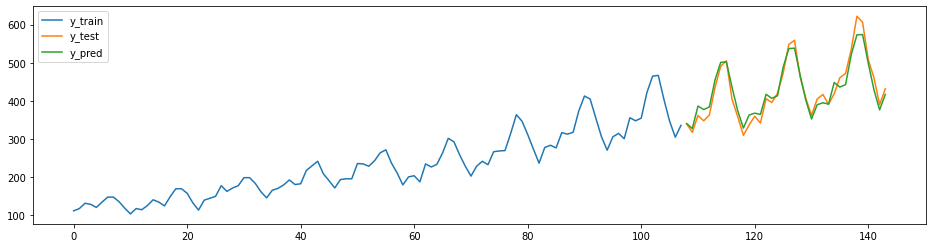

In [18]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

Of course, we could try again to optimise the hyper-parameters of components of the pipeline.

Below we discuss two other aspects of forecasting: online learning, where we want to dynamically update forecasts as new data comes in, and prediction intervals, which allow us to quantify the uncertainty of our forecasts.

## Dynamic forecasts

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, all forecasters in sktime have a `update_predict` method. Here we make repeated single-step ahead forecasts over the test set.

Note that the forecasting task is changed: while we still make 36 predictions, we do not predict 36 steps ahead, but instead make 36 single-step-ahead predictions.

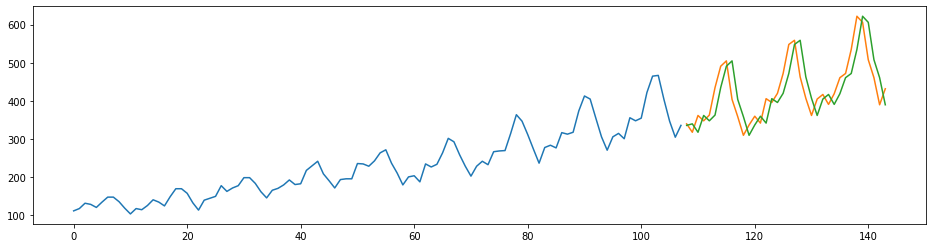

In [19]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
smape_loss(y_test, y_pred)
plot_ys(y_train, y_test, y_pred);

For a single update, you can use the `update` method.

## Prediction intervals
So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. sktime's interface support prediction intervals, but we haven't implemented them for all algorithms yet.

Here, we use the Theta forecasting algorithm:

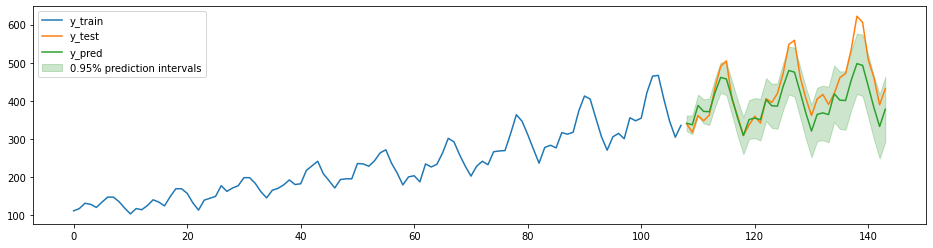

In [20]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

fig, ax = plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
plt.legend();